# Titanic Survival Model
Would you survive the Titanic? Find out using this machine learning model.

## Setup & reading the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [65]:
data = pd.read_csv('./data/train.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Here are the ages themselves, in relation to the class of the passenger.

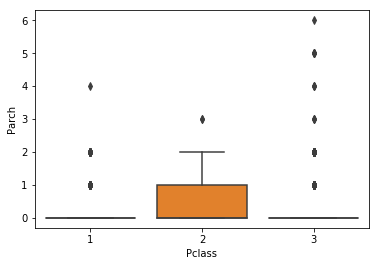

In [66]:
sns.boxplot(
    x='Pclass', y='Age',
    data=data
)

## Cleaning the data
This dataset is pretty messy right now, and there are a few things that we need to fix. First, lets get rid of unnecessary information that won't effect our model.

In [70]:
# Implement the cabin later
data = data[
    [
        'Survived',
        'Pclass',
        'Sex',
        'Age',
        'SibSp',
        'Embarked'
    ]
]

data.head()

,Survived,Pclass,Sex,Age,SibSp,Embarked
0,0,3,male,22.0,1,S
1,1,1,female,38.0,1,C
2,1,3,female,26.0,0,S
3,1,1,female,35.0,1,S
4,0,3,male,35.0,0,S


There are also a lot of null values in this dataset, which our model will not be able to understand. We can see the null values in the dataset here:

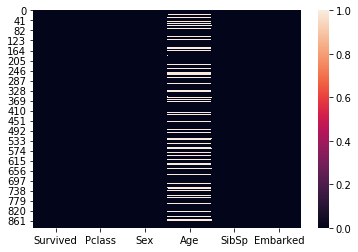

In [71]:
null_values = data.isnull()
sns.heatmap(null_values)

### Fixing the null values
First, lets write a function to fill all null-aged passengers with the average age of that passenger's class. However, before we do this, we must calcualte the mean ages for all different passenger classes.

In [72]:
age_means = data.groupby('Pclass')['Age'].mean()

In [73]:
def fill_missing_age(passenger):
    age = passenger[0]
    p_class = passenger[1]
    
    if pd.isnull(age):
        if p_class == 1:
            return age_means[1] # Average age in first class
        elif p_class == 2:
            return age_means[2] # Average age in "second class"
        else:
            return age_means[3] # Average age in "third class"
    else:
        return age

Reassign every single age in the dataset with the return of our new `fill_missing_age` function.

In [74]:
data['Age'] = data[['Age', 'Pclass']].apply(fill_missing_age, axis=1)

### Getting dummy values for gender and embarked attributes
The next line will make all `male` values `1` and all `female` values `0` from our dataset and store that information in a vector.

Then, the same thing will happen for the `Embarked` feature in the dataset.

In [75]:
gender = pd.get_dummies(data['Sex'], drop_first=True)
embark = pd.get_dummies(data['Embarked'], drop_first=True)

Now we will add these new dummy values (that our model will be able to understand, for they are numerical) into our original dataset.

In [76]:
data.drop(
    [
        'Sex',
        'Embarked'
    ],
    axis=1, inplace=True
)

data = pd.concat(
    [
        data,
        gender,
        embark
    ],
    axis=1
)

### Analysis
Now we can evaluate how well we cleaned the sex and embark data by seeing that heatmap again

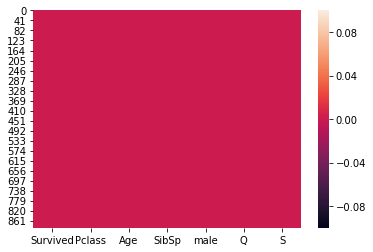

In [77]:
null_values = data.isnull()
sns.heatmap(null_values)

See? No null values in the sex feature anymore. That's good! Our data is now much cleaner.

## Visualization
Lets visualize some important data using seaborn.

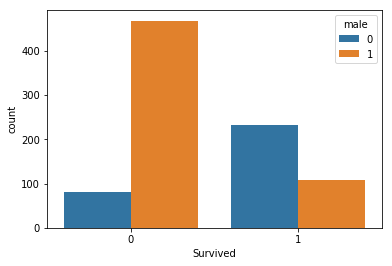

In [78]:
sns.countplot(x='Survived', hue='male', data=data)

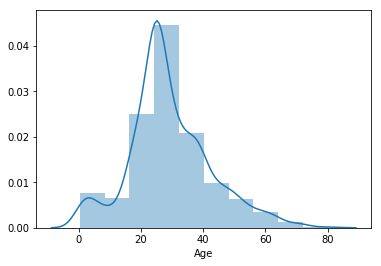

In [79]:
sns.distplot(
    data['Age'].dropna(),
    bins=10
)

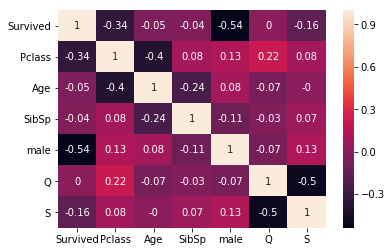

In [80]:
correlation_matrix = data.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

Note:

For the `male` feature, a `0` means female and a `1` means male.

## Training
Now it is time to train the dataset. However, we must first split the data appropriately.

In [81]:
from sklearn.model_selection import train_test_split

X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=101
)
print(X_train.head())

     Pclass   Age  SibSp  male  Q  S
520       1  30.0      0     0  0  1
510       3  29.0      0     1  1  0
446       2  13.0      0     0  0  1
2         3  26.0      0     0  0  1
691       3   4.0      0     0  0  0


Now that the data has been split, we can train the model accordingly.

In [82]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train, y_train)

/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## Analysis
Now that the model has been trained, let's see how well it will predict our testing data and analyze the accuracy of the model.

In [83]:
predictions = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       154
           1       0.80      0.65      0.72       114

   micro avg       0.78      0.78      0.78       268
   macro avg       0.79      0.77      0.77       268
weighted avg       0.79      0.78      0.78       268



## Would *you* survive the Titanic?
Now it's time to input *your* attributes and see if the model can accurately predict whether *you* would survive the Titanic.

In [86]:
p_class  = int(input('What class would you be in on the Titanic (1, 2, 3) ? '))
sex      = int(input('What is your sex (1 = male, 0 = female) ? '))
age      = int(input('What is your age ? '))
siblings = int(input('How many siblings would be on the Titanic with you ? '))

embarked = int(input('From where did you embark (0 = S, 1 = C, 2 = Q) ? '))
q, s, c = 0, 0, 0

if embarked == 0:
    s = 1
elif embarked == 1:
    c = 1
elif embarked == 2:
    q = 1
    
raw_survival_data = {
    'Pclass': [p_class],
    'male': [sex],
    'Age': [age],
    'SibSp': [siblings],
    'Q': [q],
    'S': [s]
}

survival_data = pd.DataFrame(raw_survival_data)

prediction = model.predict(survival_data)
parsed_survival = int(str(prediction)[1:-1])
predicted_survival = 'You survived the Titanic!' if parsed_survival == 1 else 'You did not survive the Titanic.'

print(predicted_survival)

What class would you be in on the Titanic (1, 2, 3) ? 1
What is your sex (1 = male, 0 = female) ? 0
What is your age ? 1
How many siblings would be on the Titanic with you ? 1
From where did you embark (0 = S, 1 = C, 2 = Q) ? 0
You survived the Titanic!
